# Defining the surface

In NemesisPy the surface can be described according to three different models selected based on the value of the lower boundary condition (*LOWBC*) flag in the *.set* file. These three models are:

- (0) The surface is assumed not to reflect any light (i.e. albedo equal to zero), but to emit it through thermal emission based on the surface temperature specified in the *.set* file and the spectral emissivity specified in the *.sur* file.
   
   
- (1) The surface is defined as a Lambertian surface, reflecting light depending only on the solar incident angle and the surface albedo, and emitting light based on the spectral emissivity in the *.sur* file. The albedo of the surface is defined based on the *GALB* parameter defined on the *.set* file. If *GALB*$\geq$0.0, then the albedo at all wavelengths is assumed to be the same and equal to *GALB*. If *GALB<0.0*, then the surface albedo is calculated from the spectral emissivity as $a(\lambda) = 1-\epsilon(\lambda)$.


- (2) The reflection of light on the surface is calculated using the Hapke semi-empirical model. In this case, the input parameters describing the reflection on surface are specified in the *.hap* file, while the thermal emissivities are specfied in the *.sur* file. 

In this notebook, we provide some examples on how the built-in functions on the Surface class can be used to define the surface parameters and better understand the different reflection models.

In [1]:
import archnemesis as ans
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import copy

/home/stem/ja22256/Documents/Projects/venv_planetary_python3.11/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-05 12:35:02,985	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Thermal emitting surface

In the case that *LOWBC* = 0, the surface is assumed to only emit through thermal emission. The emission is calculated based on the spectral surface emissivity specified in the *.sur* file and the surface temperature specified in the *.set* file, following 

\begin{equation}
    R_S(\lambda) = \epsilon (\lambda) \cdot B_\lambda(T_S),
\end{equation}

where $\epsilon (\lambda)$ is the spectral surface emissivity and $B_\lambda(T)$ is the blackbody function at temperature $T_S$.

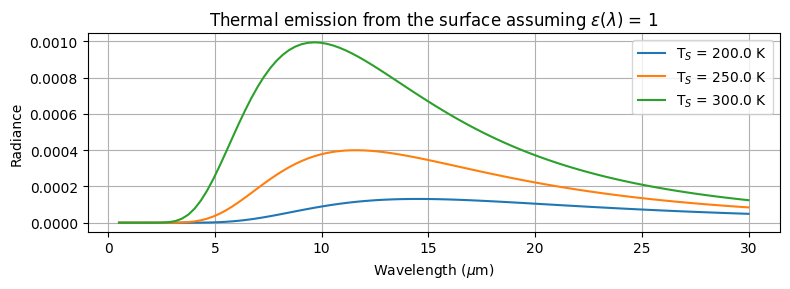

In [2]:
Surface = ans.Surface_0(LOWBC=0)


#Writing a .sur file with some values
Surface.NEM = 101
Surface.VEM = np.linspace(0.5,30.,Surface.NEM)  #0.5-20 um
Surface.EMISSIVITY = np.ones(Surface.NEM) * 1.0
runname = 'emissivity'
Surface.write_sur(runname)


#Reading the .sur file
Surface.read_sur(runname)


#Calculating the thermal emission from the surface
ISPACE = 1   #(0) Wavenumber (1) Wavelength

fig,ax1 = plt.subplots(1,1,figsize=(8,3))
tsurf = np.linspace(200.,300.,3)
for i in range(len(tsurf)):
    Surface.TSURF = tsurf[i]  
    radground = Surface.calc_radground(ISPACE)  #Calculate at the wavelengths tabulated in the .sur file

    ax1.plot(Surface.VEM,radground,label='T$_S$ = '+str(tsurf[i])+' K')
    
    
ax1.set_title('Thermal emission from the surface assuming $\epsilon(\lambda)$ = 1')
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('Radiance')
ax1.grid()
ax1.legend()
plt.tight_layout()

## Lambertian surface

In the case that *LOWBC = 1* the surface is assumed to reflect and emit light isotropically. The thermal emission is modelled using the surface emissivity values indicated in the *.sur* file. The reflectance of the surface is assumed to be independent of the direction from which it is viewed, but proportional to the amount of light incident to the surface, which varies with the solar zenith angle as $\cos(i)$. Therefore, the Lambert reflectance is calculated as

\begin{equation}
r_L (i,e,\psi) = \dfrac{A_L}{\pi} \cdot \cos(i),
\end{equation}

where $A_L$ is the Lambert albedo and $i$ is the solar incident angle, $e$ is the emission angle and $\psi$ is the azimuth angle.

The Lambert albedo of the surface is specified using the *GALB* parameter in the *.set* file. There are two possible cases:

- If *GALB*$\geq$0.0, then the Lambert albedo is given by this value and it is assumed to be spectrally constant.
- If *GALB*$\lt$0.0, then the Lambert albedo is calculated as $A_L(\lambda) = 1-\epsilon(\lambda)$, where $\epsilon$ is the surface emissivity specified on the *.sur* file

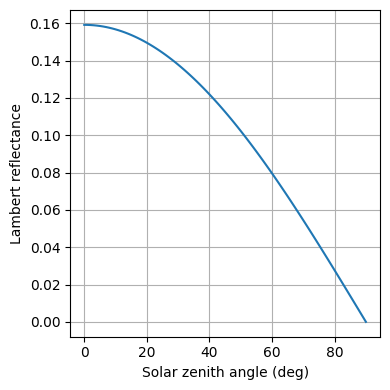

In [3]:
Surface = ans.Surface_0(GALB=0.5,LOWBC=1,NEM=1)

#Calculating the albedo (in this case it will be given by GALB at all wavelengths since GALB>0.0)
Albedo = Surface.calc_albedo()

#Calculating the variation of surface reflectance with solar zenith angle
SOL_ANG = np.linspace(0.,90.,91)                  #(NTHETA)
BRDF = Surface.calc_Lambert_BRDF(Albedo,SOL_ANG)  #(NWAVE,NTHETA)

fig,ax1 = plt.subplots(1,1,figsize=(4,4))
ax1.plot(SOL_ANG,BRDF[0,:])
ax1.grid()
ax1.set_xlabel('Solar zenith angle (deg)')
ax1.set_ylabel('Lambert reflectance')
plt.tight_layout()

## Hapke surface

In the case that *LOWBC = 2*, the surface is assumed to reflect light according to the Hapke model and to emit light isotropically through thermal emission (with the spectral emissivity defined in the *.sur* file) as in the previous cases. The parameters defining the Hapke surface specified in the *.hap* file are assumed to be defined in the same spectral grid as the surface emissivity in the *.sur* file. The input parameters defining the surface in this model are:

- $\omega$ (*SGLALB*): Single scattering albedo of the surface.
- $K$ (*K*): Porosity coefficient.
- $B_{S_0}$ (*BS0*)*: Amplitude of the opposition effect.
- $h_S$ (*hs*): Width of the opposition surge.
- $B_{c_0}$ (*BC0*): Amplitude of the backscatter effect.
- $h_c$ (*hc*): Width of the backscatter function.
- $\theta$ (*ROUGHNESS*): Roughness mean slope angle (degrees).
- *G1*, *G2* and *F* define the phase function of the surface, which is modelled using a double Henyey-Greenstein function, where *G1* and *G2* are the asymmetry factor of each of the H-G functions and *F* is the relative contribution of the two (see the Scattering example for a formal definition of the double H-G function).

The surface reflectance is then calculated using

\begin{equation}
r_H (i,e,\psi) = K \cdot \dfrac{\omega}{4\pi} \cdot \dfrac{\mu_{0e}}{\mu_{0e} + \mu_e} \cdot \left( p(g) \cdot (1+B_{S_0}B_S(g)) + (H(\mu_{0e}/K)H(\mu_e/K)-1) \right) \cdot \left( 1+B_{C_0}B_C(g) \right) \cdot S(i,e,g).
\end{equation}

The derivation of the reflectance distribution function and all required quantities is described in detail in [Hapke (2012)](https://www.cambridge.org/core/books/theory-of-reflectance-and-emittance-spectroscopy/C266E1164D5E14DA18141F03D0E0EAB0).

In [4]:
Surface = ans.Surface_0(LOWBC=2)

wave = np.linspace(0.2,0.3,2)
nwave = len(wave)

#Wavelength grid
Surface.NEM = nwave
Surface.VEM = wave

#Hapke parameters
Surface.SGLALB = np.zeros(nwave) + 0.07
Surface.K = np.zeros(nwave) + 1.0
Surface.BS0 = np.zeros(nwave) + 4.0
Surface.hs = np.zeros(nwave) + 0.055
Surface.BC0 = np.zeros(nwave) + 0.0
Surface.hc = np.zeros(nwave) + 0.01
Surface.ROUGHNESS = np.zeros(nwave) + 20.
Surface.G1 = np.zeros(nwave) + 0.66   #Forward scattering
Surface.G2 = np.zeros(nwave) - 0.2    #Backward scattering
Surface.F = np.zeros(nwave) + 0.13

#Writing the .hap file
runname = 'hapke'
Surface.write_hap(runname)

#Reading the .hap file
Surface.read_hap(runname)

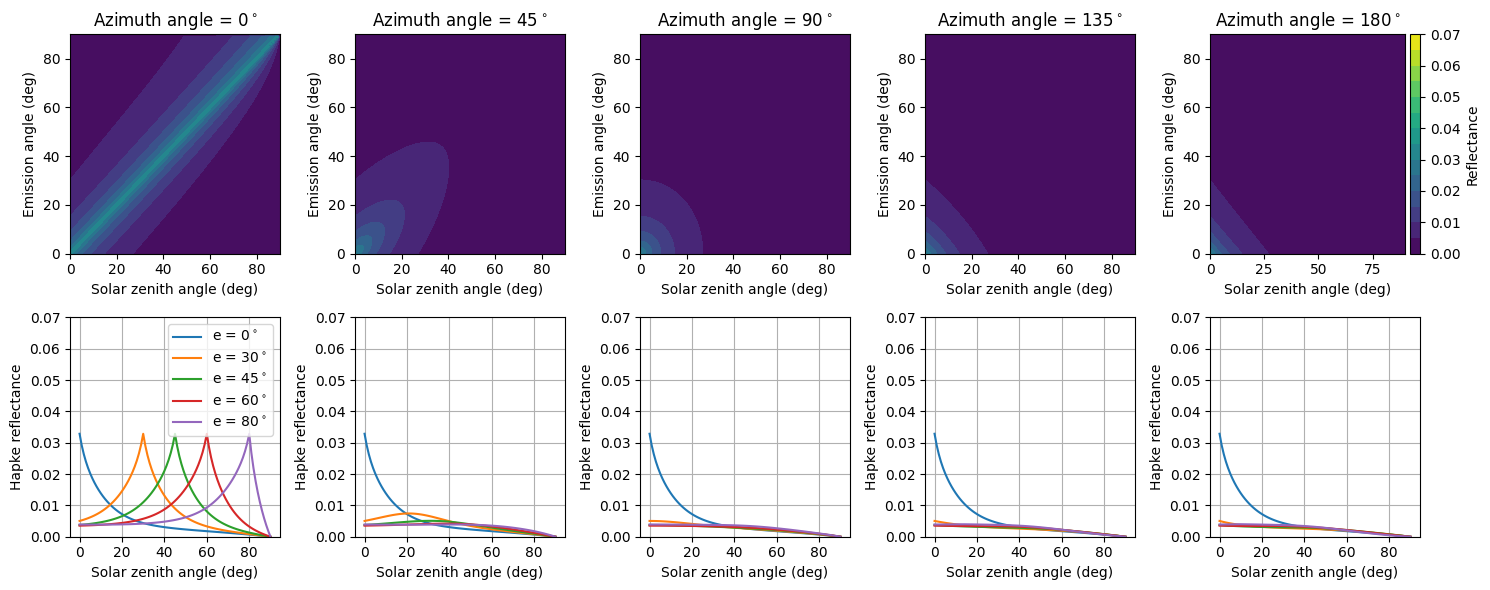

In [5]:
nphi = 5
fig,ax = plt.subplots(2,nphi,figsize=(15,6))

#Defining levels for the contour plots
levels = np.linspace(0.0,0.07,15)

#Selecting emission angles to plot
eplot = [0.,30.,45.,60.,80.]

ntheta = 91
SOL_ANG = np.linspace(0.,90.,ntheta)
EMISS_ANG = np.linspace(0.,90.,ntheta)
AZI_ANG = [0.,45.,90.,135.,180.]

for iphi in range(nphi):
    PHASE_ANG = np.zeros((ntheta,ntheta))
    BRDF = np.zeros((ntheta,ntheta))
    for iem in range(ntheta):

        EMISS_ANG1 = np.ones(ntheta) * EMISS_ANG[iem]
        SOL_ANG1 = copy(SOL_ANG)
        AZI_ANG1 = np.ones(ntheta) * AZI_ANG[iphi]

        PHASE_ANG[iem,:] = Surface.calc_phase_angle(EMISS_ANG1,SOL_ANG1,AZI_ANG1)

        BRDF1 = Surface.calc_Hapke_BRDF(EMISS_ANG1,SOL_ANG1,AZI_ANG1)
        BRDF[iem,:] = BRDF1[0,:]

    im = ax[0,iphi].contourf(SOL_ANG,EMISS_ANG,BRDF,levels=levels)
    ax[0,iphi].set_ylabel('Emission angle (deg)')
    ax[0,iphi].set_xlabel('Solar zenith angle (deg)')
    ax[0,iphi].set_title('Azimuth angle = '+str(int(AZI_ANG[iphi]))+'$^\circ$')


    for i in range(len(eplot)):
        iplot = np.argmin( np.abs(SOL_ANG-eplot[i]) )
        ax[1,iphi].plot(SOL_ANG1,BRDF[iplot,:],label='e = '+str(int(eplot[i]))+'$^\circ$')
    ax[1,iphi].grid()
    if iphi==0:
        ax[1,iphi].legend()
    ax[1,iphi].set_xlabel('Solar zenith angle (deg)')
    ax[1,iphi].set_ylabel('Hapke reflectance')
    ax[1,iphi].set_ylim(0.0,levels.max())

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax[0,nphi-1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Reflectance')

#ax.grid()

plt.tight_layout()